In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, cols_with_sig_pval, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
# Packages of forecasting models
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
# Daily sales data
milan_data_df = pd.read_csv("../datasets/milan_daily.csv", index_col=[0], parse_dates=True)
turin_data_df = pd.read_csv("../datasets/turin_daily.csv", index_col=[0], parse_dates=True)
rome_data_df = pd.read_csv("../datasets/rome_daily.csv", index_col=[0], parse_dates=True)

print("Milan sales data:", milan_data_df.shape)
print(milan_data_df.head())
print("\n")
print("Turin sales data:", turin_data_df.shape)
print(turin_data_df.head())
print("\n")
print("Rome sales data:", rome_data_df.shape)
print(rome_data_df.head())
print("\n")

# Exogenous weather data
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)

Milan sales data: (1357, 1)
            qty
time           
2016-04-14  119
2016-04-15  119
2016-04-16  206
2016-04-17  211
2016-04-18   85


Turin sales data: (1460, 1)
            qty
time           
2016-01-02  127
2016-01-03  105
2016-01-04   86
2016-01-05  213
2016-01-06  299


Rome sales data: (1460, 1)
            qty
time           
2016-01-02  110
2016-01-03  115
2016-01-04   86
2016-01-05  371
2016-01-06  294




In [3]:
def augment_store_data (store_df, loc_weather_df):
    ## STORE DATA
    store_daily_totals = store_df.copy(deep=True)
    # No pre-processing or cleaning needed, we are sure there are no missing values for each present day
  
    ## WEATHER DATA
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "PRESSIONEMEDIA mb", "PIOGGIA mm", "FENOMENI"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_daily_totals.index[0]:,:]
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_daily_weather_augmented = store_daily_totals.copy(deep=True)
    day_yearly_nr = np.array(list(map(int, store_daily_totals.index.strftime('%j').tolist())))
    nrm_days = day_yearly_nr/365
    store_daily_weather_augmented["sin_day"] =  np.sin((day_yearly_nr/365) * 2*np.pi)
    store_daily_weather_augmented["cos_day"] = np.cos((day_yearly_nr/365) * 2*np.pi)
    store_daily_weather_augmented["sincos_day"] = np.sin((day_yearly_nr/365) * 2*np.pi) * np.cos((day_yearly_nr/365) * 2*np.pi)
    for w_col in loc_weather_df.columns:
        store_daily_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
   
    # Find and replace NAN values in sales and replace them if they are present
    nan_indices = store_daily_weather_augmented[loc_weather_df.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        n_days_before = nan_idx - timedelta(days=3)
        before_nan = nan_idx - timedelta(days=1)
        store_daily_weather_augmented.fillna(np.mean(store_daily_weather_augmented.loc[n_days_before:before_nan]), inplace=True)

    return store_daily_totals, store_daily_weather_augmented

# Augment single location sales data and then put everything together
milan_daily_default, milan_daily_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_daily_default.shape)
print("Milan + exogenous data shape:", milan_daily_augmented.shape)
turin_daily_default, turin_daily_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_daily_default.shape)
print("Turin + exogenous data shape:", turin_daily_augmented.shape)
rome_daily_default, rome_daily_augmented = augment_store_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_daily_default.shape)
print("Rome + exogenous data shape:", rome_daily_augmented.shape)

Milan data original shape: (1357, 1)
Milan + exogenous data shape: (1357, 14)
Turin data original shape: (1460, 1)
Turin + exogenous data shape: (1460, 14)
Rome data original shape: (1460, 1)
Rome + exogenous data shape: (1460, 14)


In [4]:
## Create dicts for different store data
datasets = {
    "Milan": milan_daily_augmented,
    "Turin": turin_daily_augmented, 
    "Rome": rome_daily_augmented
}

In [5]:
for dataset in datasets:
    datasets[dataset].to_csv(dataset+".csv")

# Data Visualization and Exploration 

Milan data 

[0.0, 0.2473, 0.0, 0.174, 0.0, 0.0, 0.0012, 0.0, 0.8919, 0.0026, 0.0003, 0.0137, 0.8859, 0.0]


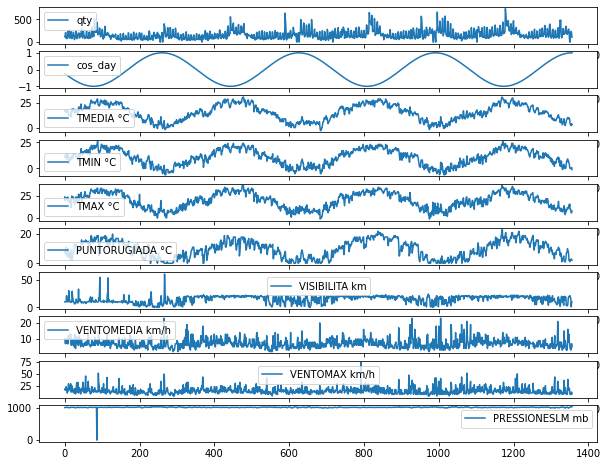

Turin data 

[0.0, 0.0012, 0.4081, 0.0, 0.0425, 0.1118, 0.0413, 0.5472, 0.1156, 0.0653, 0.4544, 0.7543, 0.1765, 0.265]


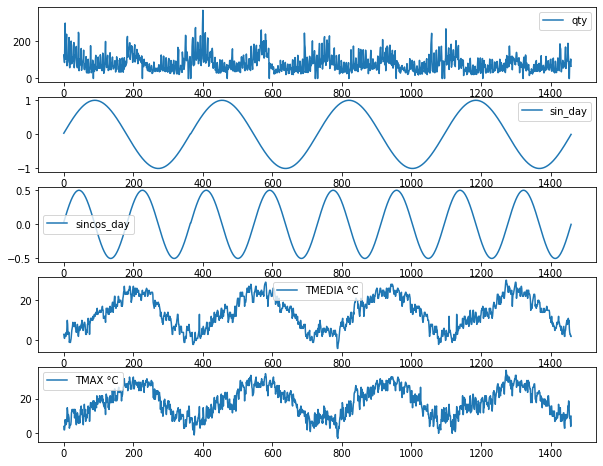

Rome data 

[0.0, 0.5971, 0.1155, 0.0, 0.8028, 0.4718, 0.8111, 0.9787, 0.0099, 0.0, 0.6555, 0.2869, 0.0, 0.2828]


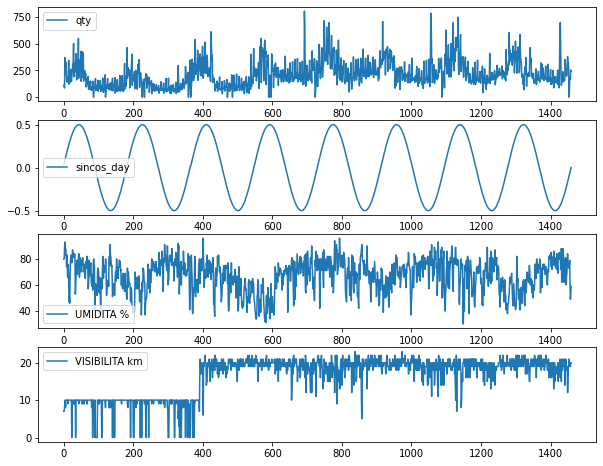

In [6]:
# Plot the data to explore and see what we are working with
for dataset in datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = datasets[dataset].values
    cols_to_plot = cols_with_sig_pval(datasets[dataset])
    
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

# LSTM helper functions

In [7]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")
    return inp_tr, out_tr, inp_te, out_te

def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, te_df, input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=256, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

def check_lstm_forecast_results(pred, inp_te, out_te, mean, std, in_len, out_len):
    # Rescales the data back to nrm vals first
    pred_vec = (pred[:,-out_len:,0].detach().cpu().numpy() * std) + mean
    real_vec = (out_te[:,:,0] * std) + mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    return rmse, mae

def build_lstm_full_preds(out_sq, pred_seq, out_len, mean, std):
    lstm_step_preds = []
    for i in range(0, out_sq.shape[0], out_len):
        #print((out_sq[i,:,0]*std)+mean)
        #print(((pred_seq[i,-lstm_out_len:,0].detach().cpu().numpy()*std)+mean))
        lstm_step_preds.extend(((pred_seq[i,-out_len:,0].detach().cpu().numpy()*std)+mean))
          
    lstm_step_preds.extend(((pred_seq[79,-9:,0].detach().cpu().numpy()*std)+mean))  
    return lstm_step_preds

def check_local_res(testset, preds, inp_te, out_te, mean, std, in_len, out_len):
    
    seq_nr = out_te.shape[0]
    selected_seq = [0, int(seq_nr/2), seq_nr-1]
    idx_for_seq = [testset.index[val:val+in_len+out_len] for val in selected_seq]
    idx_for_seq
    for i, seq in enumerate(selected_seq):
        input_vec = (inp_te[seq,:,0]*std)+mean
        real_vec = (out_te[seq,:,0]*std)+mean
        full_gt_vec = input_vec.tolist()
        full_gt_vec.extend(real_vec.tolist())

        plt.figure(figsize=(16,8))
        plt.plot(idx_for_seq[i], full_gt_vec, label="Train")
        plt.plot(idx_for_seq[i][in_len:], real_vec, label="Expected Output")

        for j, pred in enumerate(preds):
            curr_pred = preds[j]
            pred_vec = (curr_pred[seq,-out_len:,0].detach().cpu().numpy()*std)+mean
            plt.plot(idx_for_seq[i][in_len:], pred_vec, label="Forecast " + str(j))
            rmse = sm.tools.eval_measures.rmse(real_vec, pred_vec)
            mae = sm.tools.eval_measures.meanabs(real_vec, pred_vec)
            print("Forecast " + str(j) + " RMSE and MAE", rmse, mae)
        plt.legend()
        plt.show()

In [8]:
milan_daily_augmented["day_of_week"] = milan_daily_augmented.index.dayofweek
## Get one hot encoding of columns B
#one_hot_dow = pd.get_dummies(milan_daily_augmented['day_of_week'])
#one_hot_dow
## Drop column B as it is now encoded
#milan_daily_augmented = milan_daily_augmented.drop('day_of_week',axis = 1)
## Join the encoded df
#milan_daily_augmented = milan_daily_augmented.join(one_hot_dow)
#milan_daily_augmented

In [9]:
milan_daily_augmented

,qty,sin_day,cos_day,sincos_day,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,day_of_week
time,,,,,,,,,,,,,,,
2016-04-14,119,9.721182e-01,-0.234491,-2.279533e-01,17.0,11.0,24.0,8.0,58.0,10.0,10.0,19.0,0.0,1008.0,3
2016-04-15,119,9.679378e-01,-0.251190,-2.431364e-01,16.0,12.0,20.0,8.0,57.0,10.0,9.0,17.0,0.0,1012.0,4
2016-04-16,206,9.634705e-01,-0.267814,-2.580312e-01,17.0,11.0,21.0,7.0,53.0,10.0,7.0,17.0,0.0,1011.0,5
2016-04-17,211,9.587178e-01,-0.284359,-2.726202e-01,17.0,14.0,21.0,11.0,65.0,10.0,9.0,19.0,0.0,1010.0,6
2016-04-18,85,9.536810e-01,-0.300820,-2.868861e-01,17.0,13.0,23.0,8.0,57.0,10.0,9.0,24.0,33.0,1011.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,194,-6.880243e-02,0.997630,-6.863939e-02,3.0,0.0,10.0,2.0,85.0,17.0,4.0,9.0,0.0,1023.0,4
2019-12-28,228,-5.161967e-02,0.998667,-5.155085e-02,3.0,0.0,9.0,2.0,87.0,16.0,3.0,8.0,0.0,1030.0,5
2019-12-29,233,-3.442161e-02,0.999407,-3.440121e-02,2.0,0.0,6.0,3.0,97.0,1.0,4.0,9.0,0.0,1034.0,6


# Forecasting evaluation

Run # 1
(1222, 15) (135, 15)
MONO-LSTM input features: [0]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Inputs for training
(1167, 42, 1)
Outputs for training
(1167, 14, 1)
Inputs for testing
(80, 42, 1)
Outputs for testing
(80, 14, 1)


Inputs for training
(1167, 42, 15)
Outputs for training
(1167, 14, 15)
Inputs for testing
(80, 42, 15)
Outputs for testing
(80, 14, 15)


Training the MONO-LSTM model...
Epoch 1 Train loss: 0.97. Validation loss: 0.85. Avg future: 15.78. Elapsed time: 4.70s.
Epoch 2 Train loss: 0.88. Validation loss: 0.86. Avg future: 14.22. Elapsed time: 4.56s.
Epoch 3 Train loss: 0.84. Validation loss: 0.81. Avg future: 15.44. Elapsed time: 4.85s.
Epoch 4 Train loss: 0.76. Validation loss: 0.78. Avg future: 15.94. Elapsed time: 5.54s.
Epoch 5 Train loss: 0.76. Validation loss: 0.76. Avg future: 14.61. Elapsed time: 10.56s.
Epoch 6 Train loss: 0.72. Validation loss: 0.73. Avg future: 15.67. Elapsed time: 7.58s.
Epoch 7 Train l

Forecast 0 RMSE and MAE 71.79375778284145 53.271125248500276
Forecast 1 RMSE and MAE 54.930239752390065 43.667994907924104


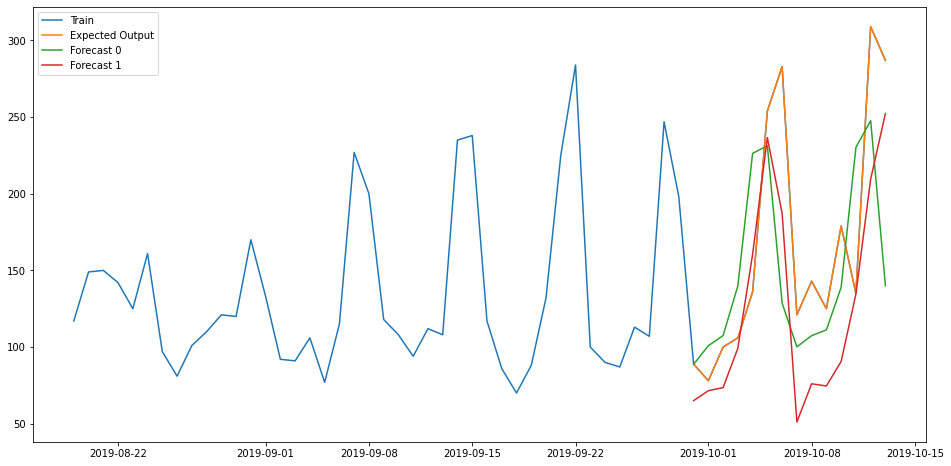

Forecast 0 RMSE and MAE 64.51634197837753 48.067253657749724
Forecast 1 RMSE and MAE 63.96581820190536 50.19710486275809


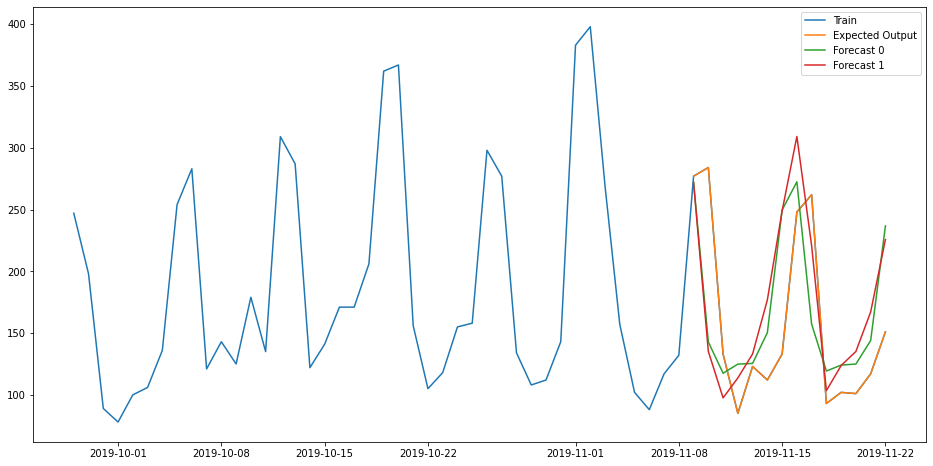

Forecast 0 RMSE and MAE 81.48565279534284 67.08009556361607
Forecast 1 RMSE and MAE 108.19368533834248 93.24000004359654


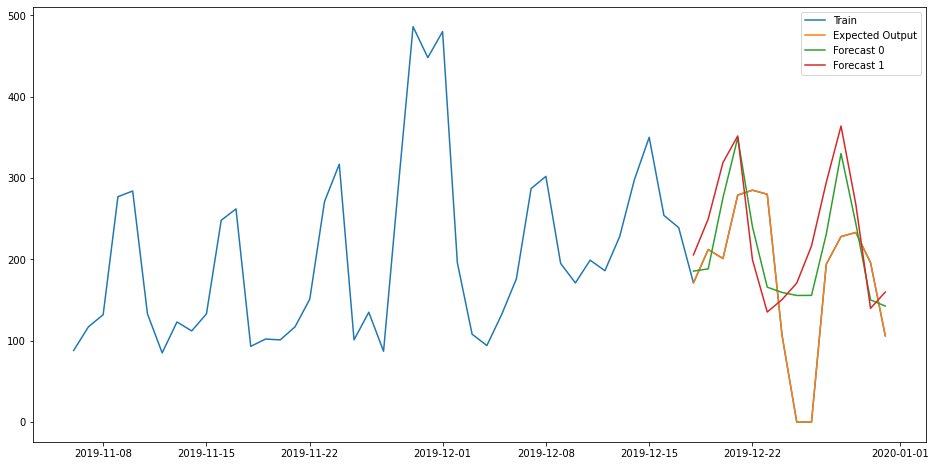

In [30]:
single_run_results = []
n_runs = 1
#for dataset in datasets:
#    print("Running forecasting for sales in", dataset, "\n")
for run in range(n_runs):
    print ("Run #", run+1)

    # Add day of week as one hot encoded signal before running the lstm model
    full_dataset = milan_daily_augmented

    # Create training and test data
    train, test = ts_train_test_split(full_dataset, test_length=0.1)
    print(train.shape, test.shape)

    # Extract the columns which display most correlation with the value we are trying to predict.
    mono_input_features = [0]
    exo3_input_features = list(range(0,full_dataset.shape[1]))
    print("MONO-LSTM input features:", mono_input_features)
    print("EXO3 (+ all exog) input features :", exo3_input_features)
    print()

    # Define steps ahead to forecast
    lstm_in_len = 42
    lstm_out_len = 14

    ## LSTM
    # Define the LSTM Models and their Optimizer objects
    mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
    exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)


    # 1) MONO-LSTM data
    mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=lstm_in_len, out_len=lstm_out_len)
    mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
    mono_x_test=torch.Tensor(mono_inp_te)

    # 2) EXO3-LSTM data
    exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=lstm_in_len, out_len=lstm_out_len)
    exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
    exo3_x_test=torch.Tensor(exo3_inp_te)

    # Train all the LSTMs 
    print("Training the MONO-LSTM model...")
    mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                       do_teacher_forcing=True, n_epochs=20, batch_size=64)
    print("Done\n")
    print("Training the EXO3-LSTM model...")
    exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
                       do_teacher_forcing=True, n_epochs=20, batch_size=64)
    print("Done\n")        


    # Make predictions using the trained networks
    mono_pred = mono_LSTM_Model(mono_x_test, lstm_out_len)
   
    exo3_pred = exo3_LSTM_Model(exo3_x_test, lstm_out_len)



    ## Check results of LSTM forecasts (calc erros)
    mean = np.mean(train.qty.values)
    std = np.std(train.qty.values)
    full_mono_pred = build_lstm_full_preds(mono_out_te, mono_pred, lstm_out_len, mean, std)
    mono_lstm_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_len:].values, full_mono_pred)
    mono_lstm_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_len:].values, full_mono_pred)
  
    full_exo3_pred = build_lstm_full_preds(exo3_out_te, exo3_pred, lstm_out_len, mean, std)
    exo3_lstm_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_len:].values, full_exo3_pred)
    exo3_lstm_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_len:].values, full_exo3_pred)


    fig = go.Figure()
    full_labels = list(range(0,test.shape[0]))
    pred_labels = list(range(lstm_in_len,test.shape[0]))
    fig.add_trace(go.Scatter(x=full_labels, y=test.qty,
                mode='lines', name='GT'))
    fig.add_trace(go.Scatter(x=pred_labels, y=full_mono_pred,
                 mode='lines', name="MONO-LSTM. RMSE %.2f" % mono_lstm_rmse ))
    fig.add_trace(go.Scatter(x=pred_labels, y=full_exo3_pred,
                 mode='lines', name="EXO3-LSTM. RMSE %.2f" % exo3_lstm_rmse))

    fig.update_layout(
        title="Forecast of test set",
        xaxis_title="Time steps",
        yaxis_title="Prediction",
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#7f7f7f"
        )
    )
    fig.show()
    check_local_res(test, [mono_pred, exo3_pred], mono_inp_te, mono_out_te, mean, std, lstm_in_len, lstm_out_len)


    #pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"daily-sales-results.html")
    single_run_results.append([dataset, "run "+str(run+1), mono_lstm_rmse, exo3_lstm_rmse, mono_lstm_mae, exo3_lstm_mae])

    print() 